In [12]:
%reload_ext autoreload
%autoreload 2
from analysis import *
import astropy.units as u
import photutils

from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import SqrtStretch

from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry

plt.style.use(astropy_mpl_style) 

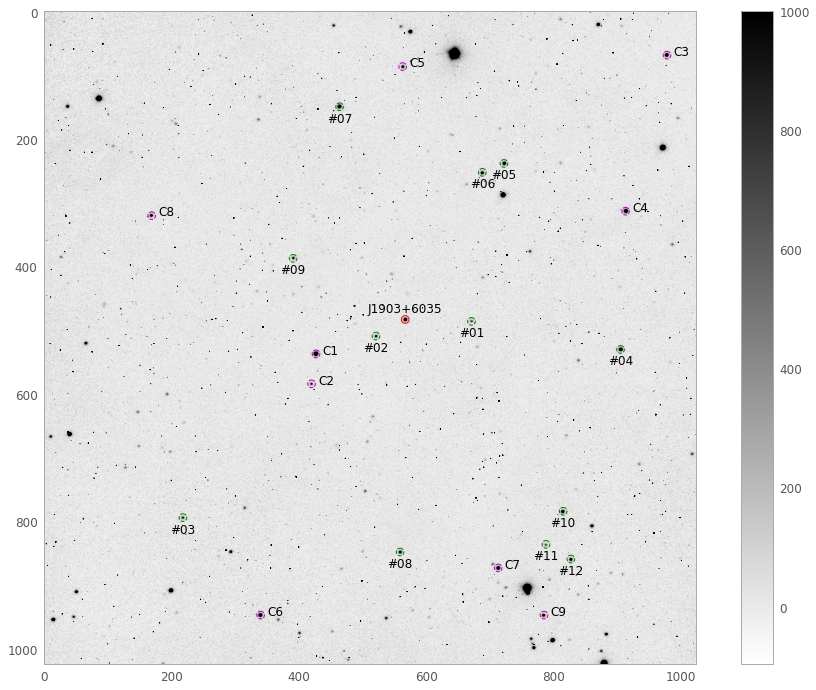

In [34]:
base = './data'
master_bias = CCDData(fits.getdata(os.path.join(base, 'processed/master_bias.fits'), ext=0), unit=u.electron)
master_flat = CCDData(fits.getdata(os.path.join(base, 'processed/master_flat.fits'), ext=0), unit=u.electron)

star = (567, 483)
ref_stars = [(671, 486), (521, 509), (218, 794), (905, 530), 
             (722, 238), (688, 252), (464, 149), (559, 848), 
             (391, 387), (815, 784), (788, 836), (827, 859)]
control = [(427, 537), (420, 584), (978, 68), (913, 313), (563, 86), (340, 947), (713, 873), (169, 320), (785, 947)]


gain = 1.25*u.electron/u.adu
readnoise = 11.8*u.electron

all_frames = load_frames(base)
good_ids = np.setdiff1d(np.arange(3, 100), range(45, 49))
good_frames = take_frames(all_frames, good_ids)

show_field(load_image(good_frames.iloc[76], master_bias, master_flat, gain, readnoise), star, ref_stars, control)

array([ 8.56970467, 10.65426352])

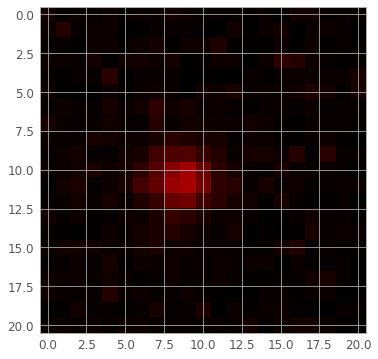

In [3]:
img = load_image(good_frames.iloc[76], master_bias, master_flat, gain, readnoise).data

pos, sub_pos, sub_img = optimize_star(img, ref_stars[10], 5)

plt.imshow(sub_img, vmax=2000)
sub_pos

In [5]:
from photutils.psf import IterativelySubtractedPSFPhotometry, BasicPSFPhotometry
from photutils.detection import IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm

sigma_psf = 2.0

bkgrms = MADStdBackgroundRMS()
std = bkgrms(sub_img)
iraffind = IRAFStarFinder(threshold=3.5*std,
                          fwhm=sigma_psf*gaussian_sigma_to_fwhm,
                          minsep_fwhm=0.01, roundhi=5.0, roundlo=-5.0,
                          sharplo=0.0, sharphi=2.0)
daogroup = DAOGroup(2.0*sigma_psf*gaussian_sigma_to_fwhm)
mmm_bkg = MMMBackground()
fitter = LevMarLSQFitter()
psf_model = IntegratedGaussianPRF(sigma=sigma_psf)

psf_model.x_0.fixed = True
psf_model.y_0.fixed = True

pos = Table(names=['x_0', 'y_0'], data=[[10],
                                        [10]])

from photutils.psf import IterativelySubtractedPSFPhotometry
# photometry = IterativelySubtractedPSFPhotometry(finder=iraffind,
#                                                 group_maker=daogroup,
#                                                 bkg_estimator=mmm_bkg,
#                                                 psf_model=psf_model,
#                                                 fitter=LevMarLSQFitter(),
#                                                 niters=3, fitshape=(7,7))

photometry = BasicPSFPhotometry(group_maker=daogroup,
                                bkg_estimator=mmm_bkg,
                                psf_model=psf_model,
                                fitter=LevMarLSQFitter(),
                                fitshape=(11,11))

result_tab = photometry(image=sub_img, init_guesses=pos)
residual_image = photometry.get_residual_image()
# result_tab['flux_fit'][0], result_tab['flux_unc'][0] 

result_tab

x_0,y_0,flux_0,id,group_id,x_fit,y_fit,flux_fit,flux_unc
int32,int32,float64,int32,int32,float64,float64,float64,float64
10,10,12727.772790133595,1,1,10.0,10.0,13352.743823823494,936.5859865320283


In [6]:
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkg = Background2D(img, (70, 70), filter_size=(3, 3),
                    sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

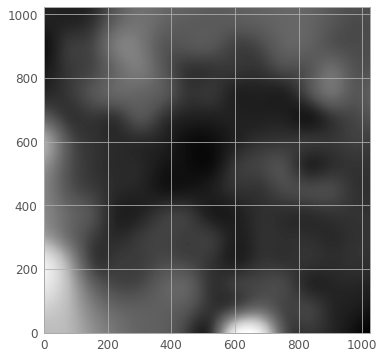

In [7]:
plt.imshow(bkg.background, origin='lower', cmap='Greys_r', interpolation='nearest')

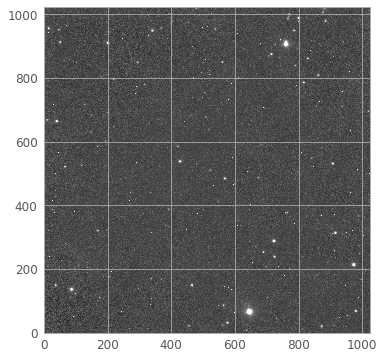

In [8]:
norm = ImageNormalize(stretch=SqrtStretch(), vmax=2000)
plt.imshow(img - bkg.background, origin='lower', cmap='Greys_r', norm=norm, interpolation='nearest')

In [10]:
positions = [star]
aperture = CircularAperture(positions, r=5)
phot_table = aperture_photometry(img, aperture)
phot_table

id,xcenter,ycenter,aperture_sum
,pix,pix,
int32,float64,float64,float64
1,567.0,483.0,47409.62000154742


In [11]:
good_frames

,index,Name,EXPTIME,FILTER,IMAGETYP,BZERO,CCD-TEMP,INSTRUME,DATE-OBS
0,3,./data\J1903+6035_sdss_g_20210513_070907.fits,100.0,sdss_g,LIGHT,32768.0,-28.078652,Flarecam,2021-05-13T07:09:07.890
1,4,./data\J1903+6035_sdss_g_20210513_071104.fits,100.0,sdss_g,LIGHT,32768.0,-28.201239,Flarecam,2021-05-13T07:11:04.810
2,5,./data\J1903+6035_sdss_g_20210513_071302.fits,100.0,sdss_g,LIGHT,32768.0,-27.085385,Flarecam,2021-05-13T07:13:02.090
3,6,./data\J1903+6035_sdss_g_20210513_071458.fits,100.0,sdss_g,LIGHT,32768.0,-26.969085,Flarecam,2021-05-13T07:14:58.450
4,7,./data\J1903+6035_sdss_g_20210513_071651.fits,100.0,sdss_g,LIGHT,32768.0,-27.028807,Flarecam,2021-05-13T07:16:51.720
...,...,...,...,...,...,...,...,...,...
88,95,./data\J1903+6035_sdss_g_20210513_100935.fits,100.0,sdss_g,LIGHT,32768.0,-27.104245,Flarecam,2021-05-13T10:09:35.620
89,96,./data\J1903+6035_sdss_g_20210513_101141.fits,100.0,sdss_g,LIGHT,32768.0,-27.160823,Flarecam,2021-05-13T10:11:41.610
90,97,./data\J1903+6035_sdss_g_20210513_101344.fits,100.0,sdss_g,LIGHT,32768.0,-27.013091,Flarecam,2021-05-13T10:13:45.650
91,98,./data\J1903+6035_sdss_g_20210513_101548.fits,100.0,sdss_g,LIGHT,32768.0,-26.984801,Flarecam,2021-05-13T10:15:48.720
